# EDA & Modeling

For this notebook, the webscraped data will be analysed and used to train models to predict data that classifies posts as belonging from r/AmiTheAsshole & r/relationships. The data was processed by removing all punctuation and a second dataset was generated by tokenizing and lemmatizing. 

The two datasets were processed using a pipeline to funnel 2 classifers (TFIDF & CountVectorizer), and 2 estimators (multinomial Naive Bayes & Logistic Regression), models were generated and evaluated based on their accuracy on the test data. The best performing model was used to get predictions on the test data and the predictions were evaluated on an ROC AUC score & model.


1. [Target Variable](#Target-Variable)
2. [Text Cleaning](#Text-Cleaning)
3. [Stop Words](#Stopwords)
4. [Tokenizing & Lemmatizing](#Preparing-a-Tokenized-&-Lemmatized-DataFrame)
5. [N-Gram Comparison](#N-Gram-Comparison)
6. [WordCloud](#WordCloud)
7. [Model Building (Base)](#Model-Building-(Base))
8. [Estimator Analysis (ROC AUC)](Estimator-Analysis-(ROC-AUC))
9. [Model Building (Tokenized & Lemmatized)](#Model-Building-(Tokenized-&-Lemmatized))
10. [Conclusion](#Conclusion)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from bs4 import BeautifulSoup  
from matplotlib_venn import venn2
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, roc_auc_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [2]:
aita = pd.read_csv('datasets/aita3.csv')
aita.shape

(1056, 104)

In [3]:
rs = pd.read_csv('datasets/rs3.csv')
rs.shape

(936, 104)

In [4]:
aita.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
0,NaN,AmItheAsshole,[This recent vice article](https://www.vice.co...,t2_7ojjg,False,NaN,1,False,New Resources for Anyone Looking to Help Those...,[],...,/r/AmItheAsshole/comments/jbswil/new_resources...,all_ads,True,https://www.reddit.com/r/AmItheAsshole/comment...,2429502,1.602785e+09,2,NaN,False,NaN
1,NaN,AmItheAsshole,Welcome to the monthly open forum! This is the...,t2_2yspbtwq,False,NaN,0,False,Monthly Open Forum November 2020,[],...,/r/AmItheAsshole/comments/jmc7kf/monthly_open_...,all_ads,True,https://www.reddit.com/r/AmItheAsshole/comment...,2429502,1.604272e+09,0,NaN,False,NaN
2,NaN,AmItheAsshole,For some background we are both 25 and live in...,t2_8kalgd95,False,NaN,0,False,AITA for moving out because my husband bought ...,[],...,/r/AmItheAsshole/comments/k13iqm/aita_for_movi...,all_ads,False,https://www.reddit.com/r/AmItheAsshole/comment...,2429502,1.606346e+09,1,NaN,False,NaN
3,NaN,AmItheAsshole,My M28 fiancee's F29 sister recently moved in ...,t2_91gkgjzf,False,NaN,0,False,AITA For wanting to sue my fiancee's sister af...,[],...,/r/AmItheAsshole/comments/k10y3h/aita_for_want...,all_ads,False,https://www.reddit.com/r/AmItheAsshole/comment...,2429502,1.606339e+09,2,NaN,False,NaN
4,NaN,AmItheAsshole,I (25F) was adopted from China as a baby. My p...,t2_91jjodnx,False,NaN,0,False,AITA for telling my brothers how it really fel...,[],...,/r/AmItheAsshole/comments/k157l8/aita_for_tell...,all_ads,False,https://www.reddit.com/r/AmItheAsshole/comment...,2429502,1.606353e+09,2,NaN,False,NaN


In [5]:
rs.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
0,NaN,relationships,My boyfriend and I have been dating for over a...,t2_3szn13h6,False,NaN,0,False,Boyfriend (34m) got tit pics from another girl...,[],...,/r/relationships/comments/k17cy1/boyfriend_34m...,all_ads,False,https://www.reddit.com/r/relationships/comment...,3001722,1.606361e+09,0,NaN,False,NaN
1,NaN,relationships,I feel absolutely disgusted and devastated bey...,t2_s6ol2,False,NaN,0,False,Found out my wife (F23) is cheating on (M24) m...,[],...,/r/relationships/comments/k16ecw/found_out_my_...,all_ads,False,https://www.reddit.com/r/relationships/comment...,3001722,1.606357e+09,0,NaN,False,NaN
2,NaN,relationships,My wife and I were college freshmen when we me...,t2_91eronoa,False,NaN,0,False,My wife (27F) is doubting our marriage because...,[],...,/r/relationships/comments/k0yld1/my_wife_27f_i...,all_ads,False,https://www.reddit.com/r/relationships/comment...,3001722,1.606331e+09,0,NaN,False,NaN
3,NaN,relationships,"this is a really long and heartbreaking story,...",t2_oj6fndj,False,NaN,0,False,should I [25M] tell my mom how much I was trau...,[],...,/r/relationships/comments/k17hcp/should_i_25m_...,all_ads,False,https://www.reddit.com/r/relationships/comment...,3001722,1.606361e+09,0,NaN,False,NaN
4,NaN,relationships,(I posted this same post about an hour ago but...,t2_91eel21b,False,NaN,0,False,I(F18) feel like my brother(24) has stolen a s...,[],...,/r/relationships/comments/k1025v/if18_feel_lik...,all_ads,False,https://www.reddit.com/r/relationships/comment...,3001722,1.606336e+09,0,NaN,False,NaN


In [6]:
aita[['title','selftext']].isnull().sum()

title       0
selftext    0
dtype: int64

In [7]:
rs[['title','selftext']].isnull().sum()

title       0
selftext    0
dtype: int64

#### Combining the two subreddits with the relevant features 

In [8]:
aita_select = aita[['title','selftext', 'subreddit']]
aita_select

,title,selftext,subreddit
0,New Resources for Anyone Looking to Help Those...,[This recent vice article](https://www.vice.co...,AmItheAsshole
1,Monthly Open Forum November 2020,Welcome to the monthly open forum! This is the...,AmItheAsshole
2,AITA for moving out because my husband bought ...,For some background we are both 25 and live in...,AmItheAsshole
3,AITA For wanting to sue my fiancee's sister af...,My M28 fiancee's F29 sister recently moved in ...,AmItheAsshole
4,AITA for telling my brothers how it really fel...,I (25F) was adopted from China as a baby. My p...,AmItheAsshole
...,...,...,...
1051,AITA for sending 2 selfies to a man who paid $...,"So a few days ago this man, who two of my frie...",AmItheAsshole
1052,AITA if I call animal protective services on m...,So I haven’t called yet but for context. My mo...,AmItheAsshole
1053,AITA for my ?toxic? friend's moving drama,So Im really confused on why my friends are ly...,AmItheAsshole
1054,AITA For not going to my sister's for Christmas?,"I need some outside opinions, my sister doesnt...",AmItheAsshole


In [9]:
rs_select = rs[['title','selftext','subreddit']]
rs_select

,title,selftext,subreddit
0,Boyfriend (34m) got tit pics from another girl...,My boyfriend and I have been dating for over a...,relationships
1,Found out my wife (F23) is cheating on (M24) m...,I feel absolutely disgusted and devastated bey...,relationships
2,My wife (27F) is doubting our marriage because...,My wife and I were college freshmen when we me...,relationships
3,should I [25M] tell my mom how much I was trau...,"this is a really long and heartbreaking story,...",relationships
4,I(F18) feel like my brother(24) has stolen a s...,(I posted this same post about an hour ago but...,relationships
...,...,...,...
931,I (20F) dont know if it's too early to settle ...,I've been with this guy for the past 3 years. ...,relationships
932,My Roommate is Overstepping Boundaries,***UPDATE*** So I talked to my roommate and le...,relationships
933,How do I (21F) let my friend (20F) know that I...,Basically what the title says. This girl (20F)...,relationships
934,My [29M] girlfriend [25F] has given me an ulti...,"Hello Reddit,\n\nMy girlfriend and I have been...",relationships


In [96]:
#Op standing for original post
op = pd.concat([aita_select, rs_select], axis=0, ignore_index=True)
op.head(10)

,title,selftext,subreddit
0,New Resources for Anyone Looking to Help Those...,[This recent vice article](https://www.vice.co...,AmItheAsshole
1,Monthly Open Forum November 2020,Welcome to the monthly open forum! This is the...,AmItheAsshole
2,AITA for moving out because my husband bought ...,For some background we are both 25 and live in...,AmItheAsshole
3,AITA For wanting to sue my fiancee's sister af...,My M28 fiancee's F29 sister recently moved in ...,AmItheAsshole
4,AITA for telling my brothers how it really fel...,I (25F) was adopted from China as a baby. My p...,AmItheAsshole
5,AITA for not telling my coworkers why I don’t ...,I had a yearly review last week and my manager...,AmItheAsshole
6,AITA for canceling a date when I was told I ha...,"This guy constantly asks me out on dates. ""Can...",AmItheAsshole
7,AITA for kicking out my parents because their ...,Here’s the situation...I (27M) have my mom and...,AmItheAsshole
8,AITA for denying my parents access to my room ...,So I know it sounds weird but let me explain.\...,AmItheAsshole
9,AITA for keeping my ex husband's last name aft...,I've been married once before; my ex and I wer...,AmItheAsshole


In [97]:
op.tail(10)

,title,selftext,subreddit
1982,I really care about this girl but she doesn't ...,"So, this is about my ex gf/friend (we're both ...",relationships
1983,Anxiety from bf Snapchat score increasing,I (34f) have anxiety from past bad relationshi...,relationships
1984,I (18F) really don’t think I’m good enough for...,"Hi, first post here, sorry if I’ve done someth...",relationships
1985,I (23F) am scared to start a relationship with...,The guy that I am currently talking to and I h...,relationships
1986,How do I [29F] deal with my gift-giving anxiet...,First Christmas with my boyfriend of six month...,relationships
1987,I (20F) dont know if it's too early to settle ...,I've been with this guy for the past 3 years. ...,relationships
1988,My Roommate is Overstepping Boundaries,***UPDATE*** So I talked to my roommate and le...,relationships
1989,How do I (21F) let my friend (20F) know that I...,Basically what the title says. This girl (20F)...,relationships
1990,My [29M] girlfriend [25F] has given me an ulti...,"Hello Reddit,\n\nMy girlfriend and I have been...",relationships
1991,Can somebody tell me if I am being paranoid or...,I've just had a big bust up with a woman I've ...,relationships


In [12]:
op['subreddit'].value_counts()

AmItheAsshole    1056
relationships     936
Name: subreddit, dtype: int64

In [13]:
op.isnull().value_counts()

title  selftext  subreddit
False  False     False        1992
dtype: int64

# Target Variable
The target variable will be set as r/AmiTheAsshole as my data is weighted slightly toward it

In [14]:
#Changing AmItheAsshole to 0, relationships to 1.
op['subreddit'] = op['subreddit'].map({'AmItheAsshole': 1, 'relationships': 0})

# EDA

## Word Length

In [15]:
#Defining a function to get me the number of words for each title/post before I clean the formatting
def get_length(column):
    new_col = [len(x) for x in column.str.split(' ')]
    return new_col

In [16]:
op['title_len'] = get_length(op['title'])
op['selftext_len'] = get_length(op['selftext'])
op.head()

,title,selftext,subreddit,title_len,selftext_len
0,New Resources for Anyone Looking to Help Those...,[This recent vice article](https://www.vice.co...,1,14,685
1,Monthly Open Forum November 2020,Welcome to the monthly open forum! This is the...,1,5,90
2,AITA for moving out because my husband bought ...,For some background we are both 25 and live in...,1,10,624
3,AITA For wanting to sue my fiancee's sister af...,My M28 fiancee's F29 sister recently moved in ...,1,14,580
4,AITA for telling my brothers how it really fel...,I (25F) was adopted from China as a baby. My p...,1,16,529


In [17]:
op_rs = op.loc[op['subreddit']==0]
op_rs.describe().T

,count,mean,std,min,25%,50%,75%,max
subreddit,936.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
title_len,936.0,14.928419,8.243371,1.0,9.0,14.0,19.0,65.0
selftext_len,936.0,457.076923,338.426650,39.0,245.0,367.0,557.0,3717.0


In [18]:
op_aita = op.loc[op['subreddit']==1]
op_aita.describe().T

,count,mean,std,min,25%,50%,75%,max
subreddit,1056.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
title_len,1056.0,12.133523,5.091781,4.0,9.0,11.0,15.00,51.0
selftext_len,1056.0,365.425189,155.679267,63.0,242.0,353.0,494.25,956.0


### Word Count observations

It seems that r/relationships has a longer title length on average, with a mean of 14.92 words per title. While r/AmiTheAsshole had a mean title length of 12.11 words per title. 
- This could probably be surmised as the optimization of using coded language (For example, a user in r/relationships would have to type out their intentions, whereas a user in r/AmiTheAsshole would use code like WIBTA(would i be the asshole) in this situation.)

</br> Both subreddits had a simliar median amount of words when it came to selftext at around 350~360 words per post. However, r/relationships has a much higher upper quartile which pushed its mean to be far higher than r/AmiTheAsshole.
<br/>(Relationships : 457 words per post length, AITA : 365.4 words per post length) 

- This also reflects in the much higher standard deviation in r/relationships : 338.4 compared to r/aita : 155.6


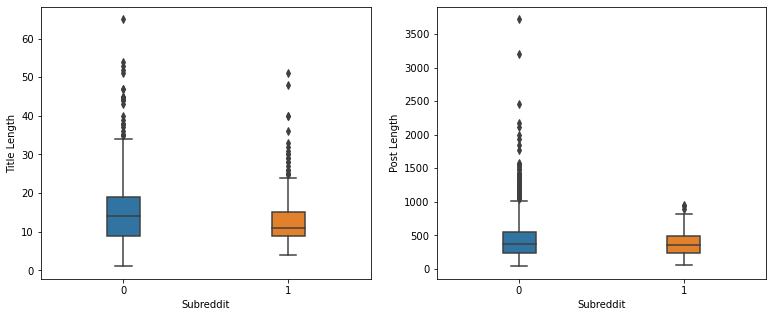

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(13,5))

sns.boxplot(x = op['subreddit'], y=op['title_len'], ax=ax1, width = 0.2)
ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Title Length')

sns.boxplot(x = op['subreddit'], y=op['selftext_len'], ax=ax2, width = 0.2)
ax2.set_xlabel('Subreddit')
ax2.set_ylabel('Post Length');


As seen in the earlier observations, r/relationships and r/AmiTheAsshole are rather similar around their median. Where they seem to differ is in the larger amount of r/relationships titles & posts that are outliers. It's quite likely that AITA sees a higher amount of moderation since posts there need to be approved before they are visible to the public. For r/relationships, there is significantly less moderation and this could have resulted in more outliers for this set of data.   

# Text Cleaning

## Stopwords

In [20]:
#Assigning stopwords
stop_words = set(stopwords.words('english'))  
special_stops = {'aita', 'asshole', 'wibta', 'yta', 'nta', 'esh', 'nah', 'info', 'relationship', 'relationships', 
                 'www', 'https', 'com' , 'reddit', 'husband', 'wife', 'girlfriend', 'boyfriend', 'bf' , 'gf', 'tl',
                 'dr', 'tldr'}
stop_words = stop_words.union(special_stops)

In [21]:
def clean_words(text):
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(text).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Remove stopwords.
    meaningful_words = [w for w in words if not w in stop_words]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [22]:
#Cleaning title text
op['title'] = op['title'].apply(clean_words)
op['title'].head()

0    new resources anyone looking help unhealthy ab...
1                          monthly open forum november
2                                     moving bought ps
3    wanting sue fiancee sister damaged prosthetic arm
4            telling brothers really felt asian family
Name: title, dtype: object

In [23]:
#Cleaning selftext text
op['selftext'] = op['selftext'].apply(clean_words)
op['selftext'].head()

0    recent vice article vice en article z av readi...
1    welcome monthly open forum place share meta th...
2    background live bay area rent exorbitantly hig...
3    fiancee f sister recently moved us divorced ex...
4    f adopted china baby parents two biological so...
Name: selftext, dtype: object

Creating a third Column 'text' that combines the title and post text to be used as a baseline for comparison with the lemmertized/tokenized version of text. I will further explore the appropriateness of using the combined title&text during the EDA portion

In [24]:
op['text'] = op['title'] + op['selftext']

### Preparing a Tokenized & Lemmatized DataFrame 

In [79]:
#Creating instances of Lemmatizer & Tokenizer
lemmer = WordNetLemmatizer()
#The tokenizer will strip but treat the punctuation as words
tokenizer = RegexpTokenizer(r'\w+|[\'",\/+.-]')

In [26]:
op_token=pd.DataFrame(op['text'].apply(lambda x: tokenizer.tokenize(x)))

In [27]:
op_lem=pd.DataFrame(op_token['text'].apply(lambda x: ' '.join([lemmer.lemmatize(word.lower()) for word in x])))
op_lem['subreddit']=op['subreddit']

#### Preliminary EDA before modeling
<br/> During the EDA section, I will be looking to see if there is significant overlap in words used in both subreddits between their titles & post text.

In [30]:
cvec = CountVectorizer(stop_words = stop_words, ngram_range=(1,3))

In [31]:
op_aita = op.loc[op['subreddit']==1]
op_rs = op.loc[op['subreddit']==0]

In [32]:
op_aita.shape

(1056, 6)

In [33]:
op_rs.shape

(936, 6)

In [34]:
op_aita_cvec_title = cvec.fit_transform(op_aita['title'])
op_aita_cvec_title = pd.DataFrame(op_aita_cvec_title.toarray(), columns = cvec.get_feature_names())
op_aita_title_50 = op_aita_cvec_title.sum().sort_values(ascending=False).head(50)

In [35]:
op_aita_cvec_selftext = cvec.fit_transform(op_aita['selftext'])
op_aita_cvec_selftext = pd.DataFrame(op_aita_cvec_selftext.toarray(), columns = cvec.get_feature_names())
op_aita_50_selftext = op_aita_cvec_selftext.sum().sort_values(ascending=False).head(50)

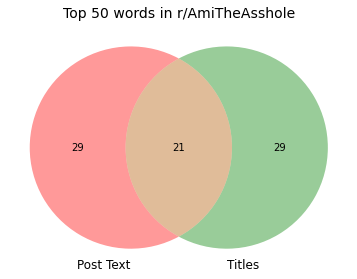

In [36]:
venn2([set(op_aita_50_selftext.index), set(op_aita_title_50.index)], set_labels = ('Post Text','Titles'))
plt.title('Top 50 words in r/AmiTheAsshole', fontsize=14)
plt.tight_layout()

### And again for r/relationships

In [37]:
op_rs_cvec_title = cvec.fit_transform(op_rs['title'])
op_rs_cvec_title = pd.DataFrame(op_rs_cvec_title.toarray(), columns = cvec.get_feature_names())
op_rs_title_50 = op_rs_cvec_title.sum().sort_values(ascending=False).head(50)

In [38]:
op_rs_cvec_selftext = cvec.fit_transform(op_rs['selftext'])
op_rs_cvec_selftext = pd.DataFrame(op_rs_cvec_selftext.toarray(), columns = cvec.get_feature_names())
op_rs_50_selftext = op_rs_cvec_selftext.sum().sort_values(ascending=False).head(50)

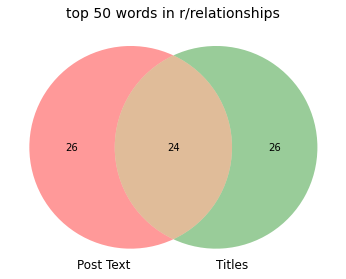

In [39]:
venn2([set(op_rs_50_selftext.index), set(op_rs_title_50.index)], set_labels = ('Post Text','Titles'))
plt.title('top 50 words in r/relationships', fontsize=14)
plt.tight_layout()

Since there seems to be a high margin of overlap it should be okay to use combined text & title moving forward.

# N-Gram Comparison

In [40]:
#Instantiating a new CountVectorizer to look for 2-3 ngrams 
cvec = CountVectorizer(stop_words = stop_words, ngram_range=(2,3))

In [41]:
#Top n-grams used in AITA 
op_aita_cvec = cvec.fit_transform(op_aita['text'])
op_aita_cvec = pd.DataFrame(op_aita_cvec.toarray(), columns = cvec.get_feature_names())
op_aita_50 = op_aita_cvec.sum().sort_values(ascending=False).head(50)

In [42]:
#Top n-grams used in RS 
op_rs_cvec = cvec.fit_transform(op_rs['text'])
op_rs_cvec = pd.DataFrame(op_rs_cvec.toarray(), columns = cvec.get_feature_names())
op_rs_50 = op_rs_cvec.sum().sort_values(ascending=False).head(50)

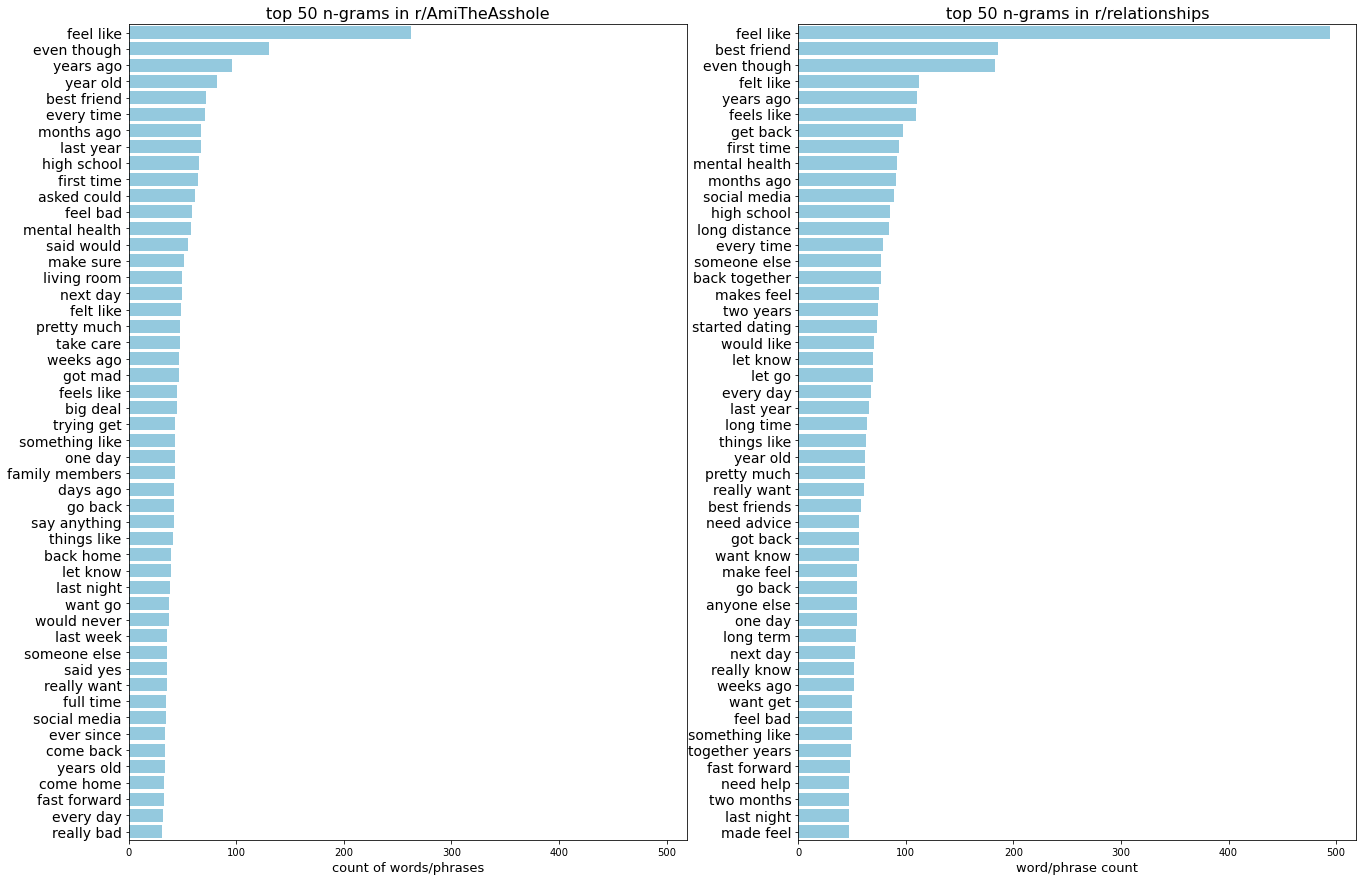

In [43]:
#Plotting out the top N-grams from both subreddits 
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(22,15), sharex = True)

sns.barplot(y=op_aita_50.index.values, x = op_aita_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 n-grams in r/AmiTheAsshole',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=op_rs_50.index.values, x = op_rs_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 n-grams in r/relationships',fontsize=16)
ax[1].set_xlabel('word/phrase count', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14);

As expected, the subreddits are largely similar in terms of language use. The top n-grams for both subreddits are 'feel like', and the top 5 for both are the same if only ordered differently. Both reddits are generally consultant subreddits where posters go to ask for advice on how situations should be handled. This seems to reflect on some of the general word usage, such as the top word 'feel like'. As most of these posts would have been situations the original poster would've felt out of their depth in, therefore asking millions of strangers online for input. 

In general though, r/relationships seems to be angled more toward relationships, with n-grams such as 'started dating','long distance'. While r/AmiTheAsshole has more language that is more confrontational and deals with conflict such as 'big deal', 'got mad', 'would never'. 


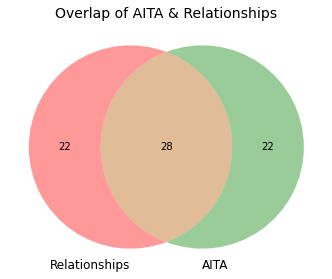

In [44]:
venn2([set(op_rs_50.index.values), set(op_aita_50.index.values)], set_labels = ('Relationships','AITA'))
plt.title('Overlap of AITA & Relationships', fontsize=14)
plt.tight_layout()

There seems to be a large overlap in 2,3 n-grams for relationships and AITA, it will be interesting to see what modeling the data can do to classify these. 

# WordCloud

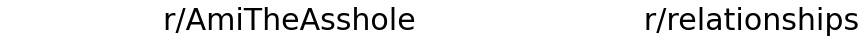

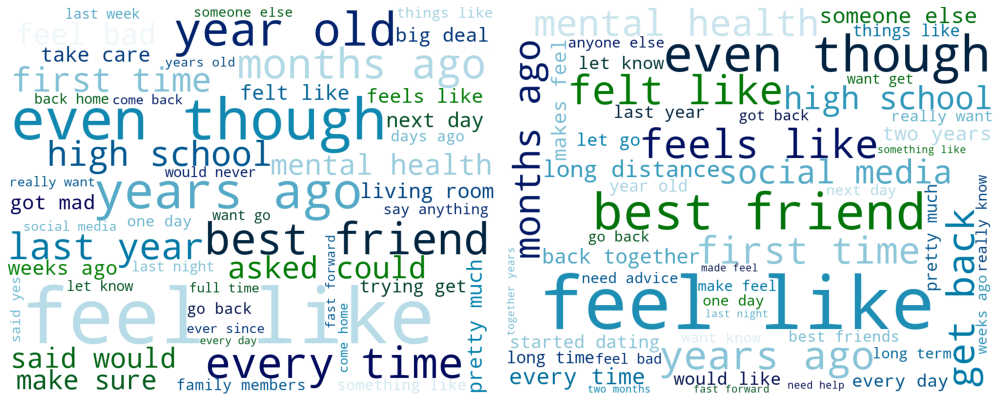

In [45]:
# set up WordCloud to show words pre-cleaning
aita_wc = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(op_aita_50) 

rs_wc = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(op_rs_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s ='r/AmiTheAsshole                        r/relationships', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(aita_wc)
ax[0].axis('off')
ax[1].imshow(rs_wc)
ax[1].axis('off')
plt.tight_layout()

# Model Building


### Baseline accuracy

In [46]:
1056/(936+1056)

0.5301204819277109

The baseline model would predict (r/AmiTheAsshole) for all posts, since it has a slightly higher percentage (53%). And it would be accurate about half the time (accuracy score = 0.53).

# Model Building (Base)
This model only includes words that are not tokenized/lemmatized

In [47]:
#Train Test Split
X = op['text']
y = op['subreddit']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.33,
                                                   random_state = 42,
                                                   stratify = y)

In [49]:
X_train.shape

(1334,)

In [50]:
y_train.shape

(1334,)

In [51]:
X_test.shape

(658,)

In [52]:
y_test.shape

(658,)

# Pipeline

In [53]:
pl = Pipeline([
    ('vectorizer', None),                                                   
    ('classifier', None),
])

In [54]:
param_grid = [{
        # vectorisers to try: count vectoriser, tf-idf vectoriser
        'vectorizer': [CountVectorizer(stop_words = stop_words, ngram_range = (1,3)),
                       TfidfVectorizer(stop_words = stop_words, ngram_range = (1,3))],
        # feature selection by max df
        'vectorizer__max_df': [0.8, 0.9],
        'vectorizer__min_df' : [2,3,4],
        'vectorizer__max_features':[1800,2100,2400],

        # models to test: multinomial Naive Bayes and logistic regression
        'classifier': [MultinomialNB(), LogisticRegression(max_iter=500)],

    }]

In [55]:
gs = GridSearchCV(pl, cv=5, param_grid = param_grid, scoring = 'accuracy', verbose = True)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)

print('Train Score:', gs.score(X_train, y_train))
print('Test Score:', gs.score(X_test, y_test))


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  6.2min finished


Train Score: 0.9250374812593704
Test Score: 0.8449848024316109


In [56]:
print(gs.best_params_)

{'classifier': LogisticRegression(max_iter=500), 'vectorizer': TfidfVectorizer(max_df=0.8, max_features=2100, min_df=2, ngram_range=(1, 3),
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'aita', 'all', 'am', 'an', 'and', 'any',
                            'are', 'aren', "aren't", 'as', 'asshole', 'at',
                            'be', 'because', 'been', 'before', 'being', 'below',
                            'between', 'bf', 'both', 'boyfriend', 'but', ...}), 'vectorizer__max_df': 0.8, 'vectorizer__max_features': 2100, 'vectorizer__min_df': 2}


In [95]:
#Extracting the features with the highest & lowest coefs for analysing
op_cvec = gs.best_estimator_.named_steps['vectorizer']

In [58]:
op_log = gs.best_estimator_.named_steps['classifier']

In [59]:
op_df = pd.DataFrame(data = [op_cvec.get_feature_names(), op_log.coef_[0]])
op_df = op_df.transpose()
op_df.columns = ['features', 'coef']

In [60]:
#exponentiate the coefficients to get the actual value
op_df['odds'] = op_df['coef'].apply(lambda x: np.exp(x))
op_df.head()

,features,coef,odds
0,able,0.0215413,1.021775
1,abroad,-0.129403,0.878620
2,absolute,-0.1161,0.890386
3,absolutely,-0.179712,0.835511
4,abuse,-0.0258648,0.974467


In [61]:
op_df.sort_values('odds').head(10)

,features,coef,odds
34,advice,-2.15867,0.115478
1613,sex,-2.09937,0.122533
1862,together,-2.06157,0.127255
434,dating,-2.04796,0.128998
1089,love,-1.99265,0.136334
640,feel,-1.90468,0.148870
971,know,-1.84432,0.158133
650,feelings,-1.75267,0.173310
1827,things,-1.68008,0.186360
1981,want,-1.51614,0.219558


In [62]:
op_df.sort_values('odds').tail(10)

,features,coef,odds
1807,telling,1.2736,3.573708
1181,mom,1.29451,3.649207
1341,pay,1.36297,3.907764
1865,told,1.42523,4.158797
435,daughter,1.44866,4.257420
1533,room,1.49336,4.452031
1570,saying,1.54996,4.711268
1651,sister,1.5734,4.823013
1548,said,1.59074,4.907382
534,edit,1.60558,4.980723


In [89]:
heads = op_df.sort_values('odds', ascending=False).head(50)
tails = op_df.sort_values('odds', ascending=True).head(50)

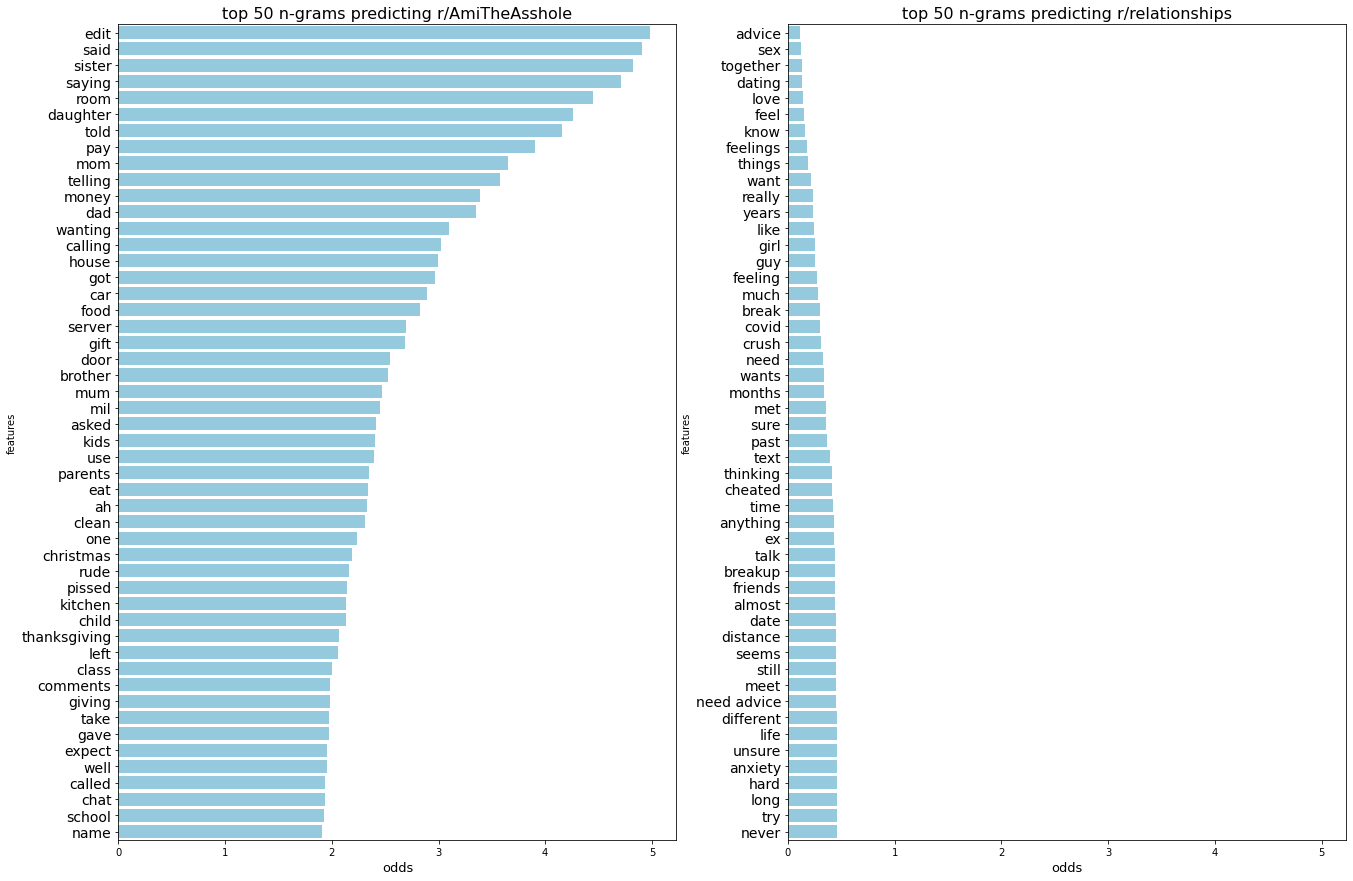

In [92]:
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(22,15), sharex = True)

sns.barplot(y=heads['features'], x = heads['odds'],color='skyblue',ax=ax[0])
ax[0].set_title('top 50 n-grams predicting r/AmiTheAsshole',fontsize=16)
ax[0].set_xlabel('odds ratio', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=tails['features'], x = tails['odds'],color='skyblue',ax=ax[1])
ax[1].set_title('top 50 n-grams predicting r/relationships',fontsize=16)
ax[1].set_xlabel('odds ratio', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14);

## Best Model Evaluation

The best model generated by the pipeline used the TfidVectorizer classifier and the Logistic Regression estimator which generated a score on the test data of 84.4%. Some interesting features were used in predicting the data. In general, the features were more or less expected. r/relationship's predictors were geared toward relationships, with features such as (guy, girl, like, dating, love, sex). However, the top predictor for r/relationships was advice, which seems to tell me more about r/AmiTheAsshole (where people could be looking for justification and not 'advice' per se). 

r/AmiTheAsshole seens to be (at least to me) where the model got creative. With the earlier mention for people seeking justification on AITA, the highest coef ended up being 'edit'. For posters in r/AITA, voters can evaluate a given situation by the original poster as (YTA) meaning you're the asshole in the situation. The original poster sometimes leaves statements such as 'edit: just wanted to give you more reasons why i'm in the right' which the model had apparently picked up on as a predictor for AITA. 
Additionally, fair mention for brother and sister being in the top coefs for differentiating r/AITA and r/relationships, since a brother or sister in the situation reduces the chances of the situation being about a partner. 

# Estimator Analysis (ROC AUC)

In [63]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [64]:
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.8252


The model has correctly classified 82.5% of the negative class (Post is from r/relationships)

In [65]:
sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.8625


The model has correctly classified 86.2% of the positive class (Post is from r/AmiTheAsshole)

In [66]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

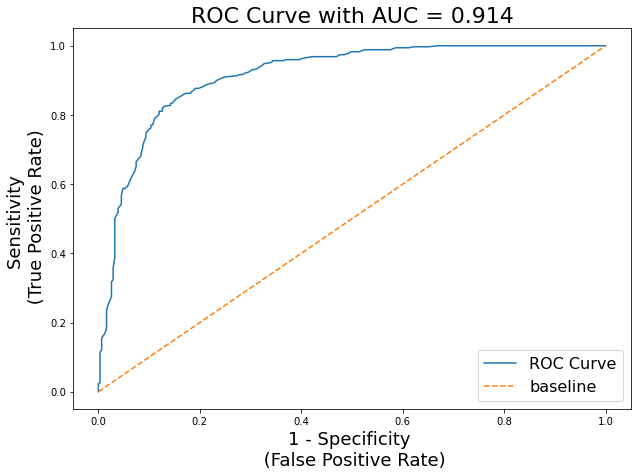

In [67]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity \n (True Positive Rate)', fontsize=18)
plt.xlabel('1 - Specificity \n (False Positive Rate)', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

The model actually achieved a respectable ROC AUC score of 0.914 which separates our populations very well. 

# Model Building (Tokenized & Lemmatized)

In [68]:
X = op_lem['text']
y = op_lem['subreddit']

In [69]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X, 
                                                    y,
                                                   test_size = 0.33,
                                                   random_state = 42,
                                                   stratify = y)

In [70]:
#Reusing the pipeline and parameters from earlier

In [71]:
gs_lem = GridSearchCV(pl, cv=5, param_grid = param_grid, scoring = 'accuracy', verbose = True)
gs_lem.fit(X_train_lem, y_train_lem)
y_pred = gs_lem.predict(X_test_lem)

print('Train Score:', gs_lem.score(X_train_lem, y_train_lem))
print('Test Score:', gs_lem.score(X_test_lem, y_test_lem))


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  6.1min finished


Train Score: 0.9242878560719641
Test Score: 0.8434650455927052


Because the scores were slightly higher on the Base Model, I decided refer back to the base for evaluation of my estimators instead.

# Conclusions

Using a pipeline to input 2 classifiers for 2 estimators on 2 dataframes, I was able to identify a model that was able to predict the test scores at an 84.4% success rate. The model correctly classified 86.2% of the positive class(r/AmiTheAsshole) and 82.5% of the negative class(r/relationships). The model actually achieved a respectable ROC AUC score of 0.914 which separated the populations very well with a reasonable degree of error.  

Upon reviewing features with the highest odd ratios from both subreddits, they to be similar in nature but with different focus. Both subreddits use language that depicts the situations that have unnerved the poster enough to have requested input from millions of strangers online, yet have their nuances that the model picked up on. For example, the use of the word 'Edit' was identified as the highest predictor feature for r/AmiTheAsshole due to user need to justify their situation through edits on their post. 